In [ ]:
!pip3 install advertorch

     |████████████████████████████████| 5.7MB 3.0MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696223 sha256=acf2e6697e7b577c635fc66a7d912db0589ca3d3412b274f68b241c4ffd402ff
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.utils import make_grid
from torchsummary import summary

from advertorch.attacks import GradientSignAttack,GradientAttack

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(7*7*64, 200)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(200, 10)

    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.relu3(self.linear1(out))
        out = self.linear2(out)
        return out


In [ ]:
device = 'cuda'
batch_size =128
test_batch_size = 64
epochs = 15
learning_rate = 0.01
weight_decay =  5e-4

In [ ]:
train_dataset = datasets.MNIST(root='../data/',train=True, download=True, 
    transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../data/', train=False, download=True, 
    transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = LeNet5()
model.to(device)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
#FOR LOOP EPOCHS
import time
start_time = time.time()


#VARIABLES,TRACKERS
for i in range(epochs):

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()}')
      
current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.17819583415985107
epoch 1 : batch  250 : loss 0.11369376629590988
epoch 2 : batch  250 : loss 0.0748509094119072
epoch 3 : batch  250 : loss 0.014221563003957272
epoch 4 : batch  250 : loss 0.036903392523527145
epoch 5 : batch  250 : loss 0.052762918174266815
epoch 6 : batch  250 : loss 0.13015873730182648
epoch 7 : batch  250 : loss 0.0416114367544651
epoch 8 : batch  250 : loss 0.05100323259830475
epoch 9 : batch  250 : loss 0.07101020961999893
epoch 10 : batch  250 : loss 0.02612755447626114
epoch 11 : batch  250 : loss 0.10115376859903336
epoch 12 : batch  250 : loss 0.12400806695222855
epoch 13 : batch  250 : loss 0.10198091715574265
epoch 14 : batch  250 : loss 0.041651107370853424
the model took 1.1669165054957071 minutes to train


Test accuracy Basic: 9792/10000 =  97.920%


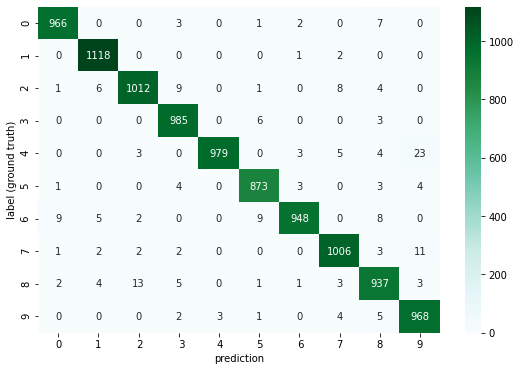

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
adversary = GradientSignAttack(model.to(device),loss_fn=nn.CrossEntropyLoss(),eps=0.25,clip_min=0.0,clip_max=1.0,targeted=True)

In [ ]:
for X_test, y_test in test_load_all:
  X_test = X_test.to(device)
  break
target = (torch.ones_like(y_test)*2).to(device)
X_adv= adversary.perturb(X_test,target)  
print(X_adv.shape)

torch.Size([10000, 1, 28, 28])


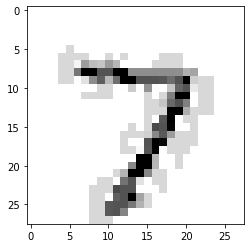

In [ ]:
plt.imshow(X_adv[0].cpu().detach().reshape(28,28),cmap="Greys")

Test accuracy Basic: 4497/10000 =  44.970%


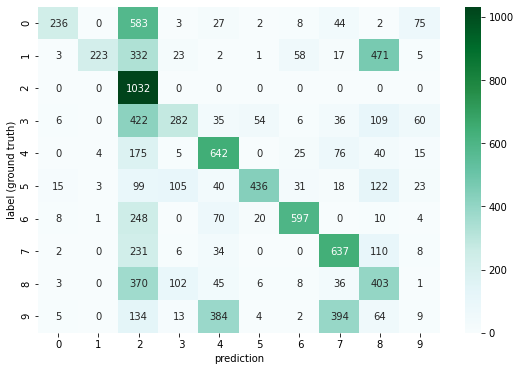

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)


correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = GradientSignAttack(model,loss_fn=nn.CrossEntropyLoss(),eps=0.25,clip_min=0.0,clip_max=1.0,targeted=True) ##
    target = (torch.ones_like(y_test)*2).to(device)   
    X_adv= adversary.perturb(X_test,target)  #@@@
    y_val = model(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [ ]:
model_adv = LeNet5()
model_adv.to(device)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_adv.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [ ]:
#FOR LOOP EPOCHS
import time
start_time = time.time()


#VARIABLES,TRACKERS
for i in range(epochs):

  for j,(X_train,y_train) in enumerate(train_loader):
    
    j+=1

    #TRAIN
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    y_pred = model_adv(X_train)
    loss = criterion(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #ADVERSARIAL TRAINING
    adversary = GradientSignAttack(model_adv.to(device),loss_fn=nn.CrossEntropyLoss(),eps=0.25,clip_min=0.0,clip_max=1.0,targeted=False)
    X_adv= adversary.perturb(X_train,y_train).to(device)  

    y_pred = model_adv(X_adv)
    loss_adv = criterion(y_pred,y_train)

    optimizer.zero_grad()
    loss_adv.backward()
    optimizer.step()
    if j% 250== 0:
      print(f'epoch {i} : batch  {j} : loss {loss.item()} : loss_adv {loss_adv.item()}')
      
current_time = time.time()
print(f'the model took {(current_time-start_time)/60} minutes to train')

epoch 0 : batch  250 : loss 0.151652991771698 : loss_adv 0.2427690625190735
epoch 1 : batch  250 : loss 0.11408627033233643 : loss_adv 0.10642313957214355
epoch 2 : batch  250 : loss 0.08881831914186478 : loss_adv 0.0883314460515976
epoch 3 : batch  250 : loss 0.1351657509803772 : loss_adv 0.1456235945224762
epoch 4 : batch  250 : loss 0.09951069951057434 : loss_adv 0.13689471781253815
epoch 5 : batch  250 : loss 0.1015978530049324 : loss_adv 0.09984605014324188
epoch 6 : batch  250 : loss 0.04917195811867714 : loss_adv 0.050573643296957016
epoch 7 : batch  250 : loss 0.1390879601240158 : loss_adv 0.08760351687669754
epoch 8 : batch  250 : loss 0.1115197166800499 : loss_adv 0.10946017503738403
epoch 9 : batch  250 : loss 0.14130479097366333 : loss_adv 0.08225278556346893
epoch 10 : batch  250 : loss 0.06271958351135254 : loss_adv 0.06135069578886032
epoch 11 : batch  250 : loss 0.1358099728822708 : loss_adv 0.15995270013809204
epoch 12 : batch  250 : loss 0.14272750914096832 : loss_adv

Test accuracy Basic: 9605/10000 =  96.050%


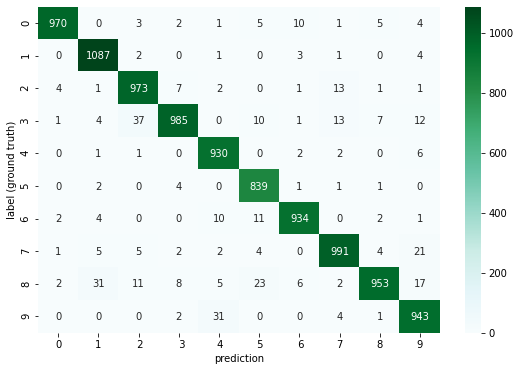

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_adv(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(predicted.view(-1).cpu(), y_test.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Test accuracy Basic: 3586/10000 =  35.860%


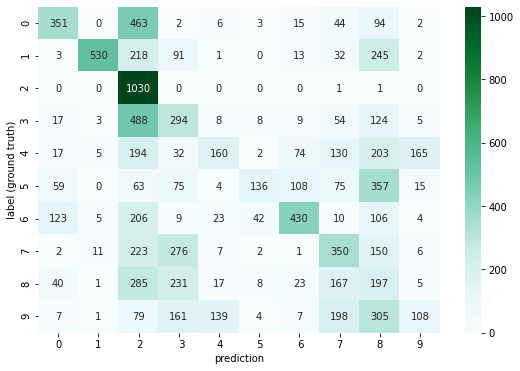

In [ ]:
test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)


correct = 0
for X_test, y_test in test_load_all:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    adversary = GradientSignAttack(model_adv,loss_fn=nn.CrossEntropyLoss(),eps=0.25,clip_min=0.0,clip_max=1.0,targeted=True) ##
    target = (torch.ones_like(y_test)*2).to(device)   
    X_adv= adversary.perturb(X_test,target)  #@@@
    y_val = model_adv(X_adv)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

class_names = ['0', '1', ' 2', '  3', ' 4', ' 5', ' 6', '7', '8', '9']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)


plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()